In [92]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
#from sklearn.metrics import 



In [93]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

-----
### Train, valid split

In [94]:
pars_smp_train = np.load('data/pars_smp_train.npy')
y_smp_train = np.load('data/y_smp_train.npy')

In [95]:
print(pars_smp_train.shape, y_smp_train.shape)

(1000000, 15, 1) (1000000, 200, 3)


In [96]:
data_border = 1000000


In [97]:
X_train, X_valid, y_train, y_valid = train_test_split(pars_smp_train[:data_border], y_smp_train[:data_border], test_size=0.2, shuffle=False, random_state=1337)

In [98]:
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)


(800000, 15, 1) (200000, 15, 1) (800000, 200, 3) (200000, 200, 3)


In [99]:
# class RNNModel(nn.Module):
#     def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
#         super(RNNModel, self).__init__()

#         # Defining the number of layers and the nodes in each layer
#         self.hidden_dim = hidden_dim
#         self.layer_dim = layer_dim

#         # RNN layers
#         self.rnn = nn.RNN(
#             input_dim, hidden_dim, layer_dim, batch_first=True #, dropout=dropout_prob
#         )
#         # Fully connected layer
#         self.fc = nn.Linear(hidden_dim, output_dim)

#     def forward(self, x):
#         # Initializing hidden state for first input with zeros
#         h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

#         # Forward propagation by passing in the input and hidden state into the model
#         out, h0 = self.rnn(x, h0.detach())

#         # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
#         # so that it can fit into the fully connected layer
#         out = out[:, -1, :]

#         # Convert the final state to our desired output shape (batch_size, output_dim)
#         out = self.fc(out)
#         return out
    
# # Определение размеров входных и выходных данных
# input_size = 3  # Размерность данных о приросте ВВП, инфляции и процентной ставке
# hidden_size = 64  # Размер скрытого состояния RNN
# output_size = 15  # Размер параметров модели
# num_layers = 2  # Количество слоев RNN
# dropout_prob = 0.01

# # Создание экземпляра модели
# model = RNNModel(input_size, hidden_size, output_size, num_layers, dropout_prob)

# # Определение функции потерь и оптимизатора
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [100]:
torch.cuda.is_available()

True

In [101]:

use_cuda = True
if use_cuda:
    device = 'cuda'
else:
    device = 'cpu'

In [102]:
class MacroEconomicModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(MacroEconomicModel, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Используйте только последний временной шаг для предсказания
        return out

# Определение размеров входных и выходных данных
input_size = 3  # Размерность данных о приросте ВВП, инфляции и процентной ставке
hidden_size = 32  # Размер скрытого состояния RNN
output_size = 15  # Размер параметров модели
num_layers = 2  # Количество слоев LSTM     
                                
# Создание экземпляра модели
model = MacroEconomicModel(input_size, hidden_size, output_size, num_layers).to(device=device)

# Определение функции потерь и оптимизатора
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [103]:
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader

# import torchvision.models as models
# import torchvision.datasets as datasets
# import torchvision.transforms as transforms


# model = models.resnet50()
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# dataset = datasets.FakeData(
#     size=1000,
#     transform=transforms.ToTensor())
# loader = DataLoader(
#     dataset,
#     num_workers=4,
#     pin_memory=True
# )

# model.to('cuda')

# for data, target in loader:
#     data = data.to('cuda', non_blocking=True)
#     target = target.to('cuda', non_blocking=True).long()
#     optimizer.zero_grad()
#     output = model(data)
#     loss = criterion(output, target)
#     loss.backward()
#     optimizer.step()
    
# print('Done')

In [104]:
# Преобразование данных в тензоры PyTorch
y_train = torch.Tensor(y_train)
X_train = torch.Tensor(X_train)

y_valid = torch.Tensor(y_valid)
X_valid = torch.Tensor(X_valid)


batch_size = 180
kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
train_dataset = TensorDataset(y_train, X_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, **kwargs)

valid_dataset = TensorDataset(y_valid, X_valid)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, **kwargs)

sss = int(X_train.shape[0]/batch_size+1)
# Обучение модели
num_epochs = 10  # Количество эпох обучения
history = {
    'training_loss':[],
    'validation_loss':[]
}
for epoch in range(num_epochs):
    model.train()
    batch_losses = []#.to(device)
    for batch in train_loader:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)
        # Обнуляем градиенты
        optimizer.zero_grad()

        # Проход вперед (forward pass)
        outputs = model(inputs)

        # Вычисление функции потерь
        loss = torch.sqrt(criterion(outputs, targets.squeeze()))
        #batch_losses.append(loss.detach().numpy())
        batch_losses.append(loss.item())
        loss.backward()
        optimizer.step()
    #print(len(batch_losses))
    training_loss = np.mean(batch_losses)
    
    with torch.no_grad():
        batch_val_losses = []
        for batch_val in valid_loader:
            inputs_val, targets_val = batch_val
            inputs_val, targets_val = inputs_val.to(device), targets_val.to(device)
            #print(inputs_val.shape, targets_val.shape)
            model.eval()

            # Проход вперед (forward pass)
            outputs_val = model(inputs_val)

            # Вычисление функции потерь
            loss_val = torch.sqrt(criterion(outputs_val, targets_val.squeeze()))
            batch_val_losses.append(loss_val)
            #print(batch_val_losses)
           # print(type(batch_val_losses))
            validation_loss = torch.mean(torch.stack(batch_val_losses))



    # Выводим информацию о процессе обучения
    #print(f'Эпоха [{epoch + 1}/{num_epochs}], Потери train: {loss.item()}')
    print(f'Эпоха [{epoch + 1}/{num_epochs}], Потери train: {training_loss.item()}, Loss valid: {validation_loss.item()}')
    history['training_loss'].append(training_loss.item())
    history['validation_loss'].append(validation_loss.item())

Эпоха [1/10], Потери train: 0.2721982822710537, Loss valid: 0.2433650642633438
Эпоха [2/10], Потери train: 0.2328355079661338, Loss valid: 0.22529596090316772
Эпоха [3/10], Потери train: 0.21848125646165306, Loss valid: 0.21329067647457123
Эпоха [4/10], Потери train: 0.21136229802572554, Loss valid: 0.20877952873706818
Эпоха [5/10], Потери train: 0.20814765686393455, Loss valid: 0.20665240287780762
Эпоха [6/10], Потери train: 0.20603470362479828, Loss valid: 0.2054162174463272
Эпоха [7/10], Потери train: 0.20420618595301904, Loss valid: 0.2035866379737854
Эпоха [8/10], Потери train: 0.2022907515880898, Loss valid: 0.20167113840579987
Эпоха [9/10], Потери train: 0.20059885534513386, Loss valid: 0.20016181468963623
Эпоха [10/10], Потери train: 0.1991256515844332, Loss valid: 0.19866353273391724


{'training_loss': [0.2721982822710537, 0.2328355079661338, 0.21848125646165306, 0.21136229802572554, 0.20814765686393455, 0.20603470362479828, 0.20420618595301904, 0.2022907515880898, 0.20059885534513386, 0.1991256515844332], 'validation_loss': [0.2433650642633438, 0.22529596090316772, 0.21329067647457123, 0.20877952873706818, 0.20665240287780762, 0.2054162174463272, 0.2035866379737854, 0.20167113840579987, 0.20016181468963623, 0.19866353273391724]}


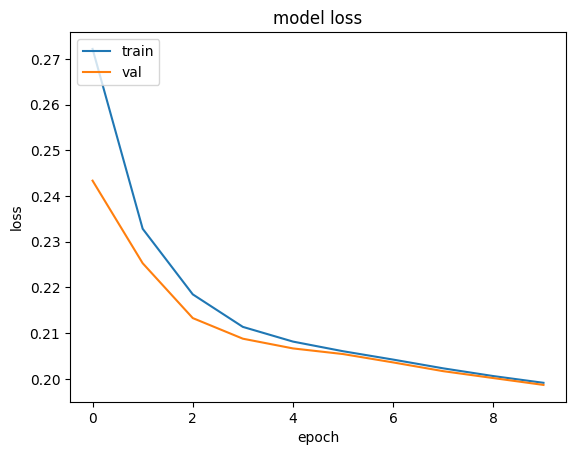

In [105]:
print(history)
from matplotlib import pyplot as plt
#plt.plot(torch.stack(history['training_loss']).cpu())
plt.plot(history['training_loss'])
plt.plot(history['validation_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [106]:
training_loss

0.1991256515844332

In [107]:
str(model)

'MacroEconomicModel(\n  (rnn): LSTM(3, 32, num_layers=2, batch_first=True)\n  (fc): Linear(in_features=32, out_features=15, bias=True)\n)'

In [108]:
import unicodedata
import re

def slugify(value):
    """
    Normalizes string, converts to lowercase, removes non-alpha characters,
    and converts spaces to hyphens.
    """
    import unicodedata
    value = unicodedata.normalize('NFKD', value).encode('ascii', 'ignore')
    value = unicode(re.sub('[^\w\s-]', '', value).strip().lower())
    value = unicode(re.sub('[-\s]+', '-', value))
    # ...
    return value

In [109]:
slugify(str(model))

NameError: name 'unicode' is not defined

In [ ]:
torch.save(model.state_dict(), 'trained_model'+str(model)+'.pth')

RuntimeError: File trained_modelMacroEconomicModel(
  (rnn): LSTM(3, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=15, bias=True)
).pth cannot be opened.